In [3]:
import pandas as pd
import scripts.scales as scales
import os

from processing.data_processing import *

# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

for k in scales.scale_titles:
    scales.scale_titles[k] = scales.scale_titles[k].replace('TiA - ', '')


# Create output and plot directories if they don't exist
plots_path = '../plots/univariate_analysis/'
os.makedirs(plots_path, exist_ok=True)

output_path = '../output/'
os.makedirs(output_path, exist_ok=True)

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())
print('\n')

# compute basic statistics for later tests
N = len(data)
p = len(tia_scales)
k = data['stimulus_group'].nunique()

# set alpha and power
alpha = 0.05
power = 0.80

print(f'Sample size: N = {N}')
print(f'Number of outcomes: p = {p}')
print(f'Number of groups: k = {k}')

Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


Sample size: N = 255
Number of outcomes: p = 5
Number of groups: k = 2


## Data Preparation

### Variable Centering and Coding

We prepare variables for moderation analysis:

1. **Effect code treatment**: stimulus_group as -0.5 (control) and 0.5 (uncertainty)
2. **Standardize continuous variables**: For better comparison of beta values between variables
3. **Effect code categorical variables**: For symmetric interpretation

In [4]:
data = effect_coding(data)

demographics = ['age', 'gender', 'education', 'ai_exp']
demographics_c = [f'{s}_c' for s in demographics]
hcsds_scales_c = [f'{s}_c' for s in hcsds_scales]
ati_scales_c = [f'{s}_c' for s in ati_scales]

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 5
Total moderators to test: 8


## Build Univariate Linear Regression Models

In [5]:
# define families of effects here to use later for MCP correction
direct_effects = demographics_c + hcsds_scales_c + ati_scales_c
interaction_effects = [f'group_effect:{eff}' for eff in direct_effects]

# build models for each tia_subscale separately
import statsmodels.formula.api as smf

results = {}
for subscale in tia_scales:
    formula = (f'{subscale} ~ group_effect '
               f'+ {' + '.join(direct_effects)}'
               f'+ {' + '.join(interaction_effects)}')

    result = smf.ols(formula, data=data).fit()

    print(f'Predicting {subscale}')
    print(result.summary())
    print(f'{'='*78}\n\n')

    results[subscale] = result

Predicting tia_f
                            OLS Regression Results                            
Dep. Variable:                  tia_f   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.658
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           0.000949
Time:                        11:27:03   Log-Likelihood:                -319.97
No. Observations:                 255   AIC:                             671.9
Df Residuals:                     239   BIC:                             728.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Interce

In [6]:
CORRECTION_METHOD = "holm"
################################

model_stats = {}

# save results to tables
for subscale in tia_scales:
    result = results[subscale]

    df = pd.DataFrame(result.summary().tables[1])

    df.iloc[0, 0] = 'effect'
    df.columns = ['effect', 'coef', 'se', 't', 'p', 'CI_lower', 'CI_higher']
    df = df[1:] # drop original header row
    df = df.set_index('effect', drop=True)

    # save to file
    df.to_csv(f'{output_path}{subscale}_regression_coef.csv', index=True)

    # save model stats for later
    model_stats[subscale] = {
        'r_squared': result.rsquared,
        'adj_r_squared': result.rsquared_adj,
        'F': result.fvalue,
        'p_for_F': result.f_pvalue,
        'df_model': result.df_model,
        'df_resid': result.df_resid
    }

model_stats_table = pd.DataFrame(model_stats)
model_stats_table.to_csv(f'{output_path}regression_model_stats.csv', index=True)
print(model_stats_table)

'''
Somehow, the `tables` object from `statsmodels` gives values as a `Cell` object instead of just numbers.
It's easiest to just save everything to a file and then read it again (very stupid, I know).
'''

# correct p-values for multiple comparisons
from statsmodels.stats.multitest import multipletests
from scripts.utils import apa_p

def convert_to_partial_eta_sq(t, df_resid):
    return t**2 / (t**2 + df_resid)

# define families
families = {
    'group': ['group_effect'],
    'direct': direct_effects,
    'interaction': interaction_effects
}

regr_res = {}
for subscale in tia_scales:
    result_df = pd.read_csv(f'{output_path}{subscale}_regression_coef.csv')
    result_df = result_df.set_index('effect')

    p_vals_adj = {}
    for fam in families.values():
        # get all relevant p values
        selection = pd.DataFrame(result_df['p'].loc[fam].copy())

        # convert to adjusted p values
        adjusted = multipletests(selection['p'],
                                 alpha=alpha,
                                 method=CORRECTION_METHOD)[1]
        selection = selection.assign(p_val_adj=adjusted)

        # add to dictionary containing adjusted p-values
        for i, row in selection.iterrows():
            p_vals_adj[i] = row['p_val_adj']

    result_df['p_adj'] = p_vals_adj

    p_adj_report = []
    partial_eta_sq = []
    for i, row in result_df.iterrows():
        p_adj_report.append(apa_p(row['p_adj'],
                                    sig_stars=True))
        partial_eta_sq.append(convert_to_partial_eta_sq(row['t'], model_stats[subscale]['df_resid']))

    result_df['partial_eta_sq'] = partial_eta_sq
    result_df['p_adj_report'] = p_adj_report

    result_df.index = [s[:-2] if s[-2:] == '_c' else s for s in list(result_df.index)]

    # save to file, overwrite original csv file
    result_df.round(decimals=3).to_csv(f'{output_path}{subscale}_regression_coef.csv', index=True)

    # also save to memory
    regr_res[subscale] = result_df

                    tia_f     tia_pro      tia_rc      tia_up         tia_t
r_squared        0.142950    0.158508    0.191100    0.071720  2.457100e-01
adj_r_squared    0.089160    0.105695    0.140332    0.013460  1.983696e-01
F                2.657561    3.001298    3.764189    1.231025  5.190284e+00
p_for_F          0.000949    0.000199    0.000006    0.249004  6.270715e-09
df_model        15.000000   15.000000   15.000000   15.000000  1.500000e+01
df_resid       239.000000  239.000000  239.000000  239.000000  2.390000e+02


## 5b. Univariate Non-Inferiority Test (ANOVA)

In [7]:
# find MDE (minimally detectable effect) in a ANOVA
from scipy import stats

def mde_regression(se, df_resid, alpha=0.05, power=0.80):
    """
    Minimally detectable effect for a regression coefficient.

    Parameters:
        se: standard error of the coefficient (from statsmodels)
        df_resid: residual degrees of freedom (model.df_resid)
        alpha: significance level (two-tailed)
        power: desired power

    Returns:
        MDE in original units of the coefficient
    """
    t_crit = stats.t.ppf(1 - alpha / 2, df_resid)  # two-tailed significance
    t_pow = stats.t.ppf(power, df_resid)           # power threshold
    return (t_crit + t_pow) * se

In [14]:
# calculate MDE (non-inferiority margin) for each DV using regression SE
ni_margin = {}

for subscale in tia_scales:
    res = regr_res[subscale]

    reg_se = res.loc['group_effect']['se']
    df = model_stats[subscale]['df_model']

    # MDE = (t_α/2 + t_β) × SE
    ni_margin[subscale] = mde_regression(reg_se, df, alpha=alpha, power=power)

print("Non-inferiority margins (MDE, as b-coefficients):")
for subscale in tia_scales:
    print(f"{subscale}:\n"
          # f"  {ni_margin[subscale]:.3f}\n")
          f"  {ni_margin[subscale]}\n")

Non-inferiority margins (MDE, as b-coefficients):
tia_f:
  0.34773256417549586

tia_pro:
  0.24880864505660477

tia_rc:
  0.20684092179404495

tia_up:
  0.2907763683191646

tia_t:
  0.28178328476290176




Non-Inferiority Test Results for 'Familiarity':
  Mean difference: M_diff = 0.175, SE = 0.116
  95% CI: [-0.0525, 0.4023]
  SESOI margin: -0.3477
  z = 4.505, p < .001
  Result: Non-inferiority established (p < .001)


Non-Inferiority Test Results for 'Propensity to Trust':
  Mean difference: M_diff = -0.040, SE = 0.083
  95% CI: [-0.2022, 0.1232]
  SESOI margin: -0.2488
  z = 2.522, p = .006
  Result: Non-inferiority established (p = .006)


Non-Inferiority Test Results for 'Reliability/Competence':
  Mean difference: M_diff = -0.096, SE = 0.069
  95% CI: [-0.2314, 0.0390]
  SESOI margin: -0.2068
  z = 1.603, p = .054
  Result: Non-inferiority not established (p = .054)


Non-Inferiority Test Results for 'Understanding/Predictability':
  Mean difference: M_diff = -0.034, SE = 0.097
  95% CI: [-0.2245, 0.1557]
  SESOI margin: -0.2908
  z = 2.643, p = .004
  Result: Non-inferiority established (p = .004)


Non-Inferiority Test Results for 'Trust in Automation':
  Mean difference: M_dif

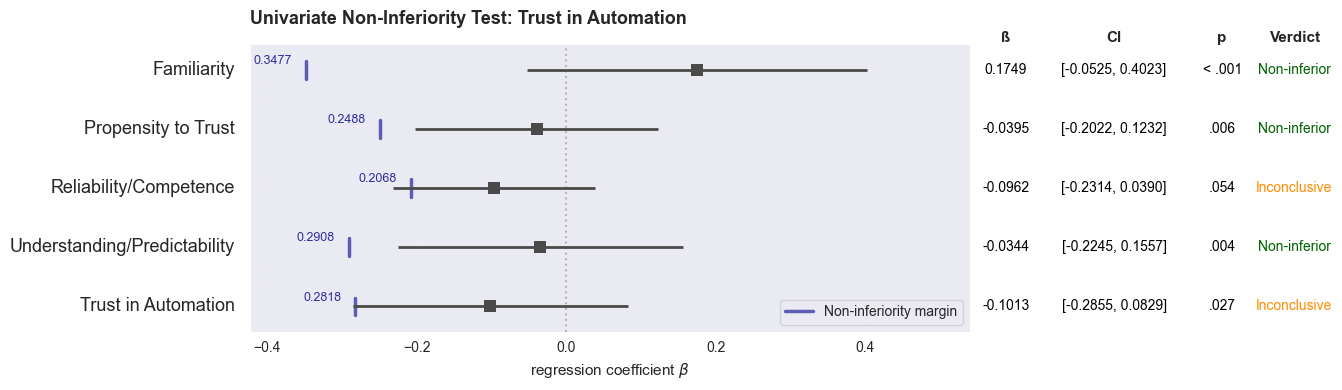

In [9]:
# Plot non-inferiority test
from scripts.viz_utils import plot_noninferiority_test
import matplotlib.pyplot as plt

# coefficients = [regr_res[subscale][regr_res[subscale]['predictor'] == 'group_effect'].iloc[0]['coef'] for subscale in tia_scales]
coefficients = [regr_res[subscale].loc['group_effect']['coef'] for subscale in tia_scales]

#  = [regr_res[subscale][regr_res[subscale]['predictor'] == 'group_effect'].iloc[0]['se'] for subscale in tia_scales]
ses = [regr_res[subscale].loc['group_effect']['se'] for subscale in tia_scales]


fig, ax = plt.subplots(figsize=(13.5, 4))
plot_noninferiority_test(
    effect_size=coefficients,
    sesoi=[ni_margin[subscale] for subscale in tia_scales],
    se=ses,
    alpha=alpha,
    variable_names=tia_scales,
    variable_labels=scales.scale_titles,
    title='Univariate Non-Inferiority Test: Trust in Automation',
    xlabel='regression coefficient $\\beta$',
    height_scale=0.5,
    column_title_pos_shift=0,
    estimate_name='ß',
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}univariate_noninferiority_test.png', dpi=150, transparent=True)
plt.show()

In [10]:
from scripts.stats import eta_confidence_interval

def eta_ci_univariate(F_obs, df_resid, alpha=0.05):
    """
    Confidence interval for partial eta² from a univariate regression coefficient.

    Parameters:
    -----------
    F_obs : float
        Observed F-value (= t² for a single coefficient)
    df_resid : int
        Residual degrees of freedom from the regression model
    alpha : float
        Significance level (default 0.05)
    """
    return eta_confidence_interval(
        F_obs=F_obs,
        df1=1,
        df2=df_resid,
        df_error=df_resid,  # same as df2 for univariate
        alpha=alpha
    )


[np.float64(2.2650249999999996), np.float64(0.22752899999999998), np.float64(1.9712159999999999), np.float64(0.126736), np.float64(1.159929)]
0.0479119263520426
[0, 0, 0, 0, 0]
[np.float64(0.0479119263520426), np.float64(0.02360914939106996), np.float64(0.04527339312436229), np.float64(0.02057867975877126), np.float64(0.03717813485427596)]

Non-Inferiority Test Results for 'Familiarity':
  Effect size: 0.0094
  95% CI: [0.0000, 0.0479]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'Propensity to Trust':
  Effect size: 0.0010
  95% CI: [0.0000, 0.0236]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority established


Non-Inferiority Test Results for 'Reliability/Competence':
  Effect size: 0.0082
  95% CI: [0.0000, 0.0453]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'Understanding/Predictability':
  Effect size: 0.0005
  95% CI: [0

<>:41: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:41: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
C:\Users\Tim Wiesner\AppData\Local\Temp\ipykernel_26740\1625081566.py:41: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  xlabel='standardized effect size $\eta_{p}^{2}$',


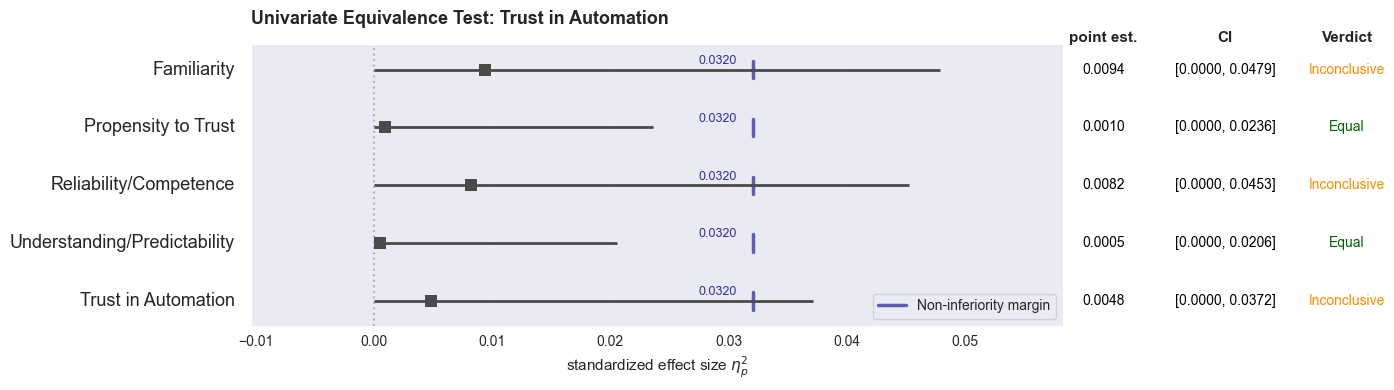

In [11]:
# equivalence test expressed in partial eta squared
df_resids = [model_stats[s]['df_resid'] for s in tia_scales]

eq_margins = [
    convert_to_partial_eta_sq((stats.t.ppf(1 - alpha / 2, df_resid) + stats.t.ppf(power, df_resid)), df_resid)
for df_resid in df_resids]


F_obs     = [regr_res[s].loc['group_effect']['t']    **2       for s in tia_scales]
coefs_eta = [regr_res[s].loc['group_effect']['partial_eta_sq'] for s in tia_scales]

print(F_obs)

cis = [eta_confidence_interval(
    F_obs=F,
    alpha=alpha,
    df1=1,
    df2=df_resid
) for (F, df_resid) in zip(F_obs, df_resids)]

print(cis[0]['eta_sq_upper'])

cis_lower_eta = [cis[i]['eta_sq_lower'] for i in range(len(F_obs))]
cis_upper_eta = [cis[i]['eta_sq_upper'] for i in range(len(F_obs))]

print(cis_lower_eta)
print(cis_upper_eta)

fig, ax = plt.subplots(figsize=(14, 4))
plot_noninferiority_test(
    effect_size=coefs_eta,
    sesoi=eq_margins,
    ci_lower_bounds=cis_lower_eta,  # Pre-computed from F-distribution
    ci_upper_bounds=cis_upper_eta,
    alpha=alpha,
    test_type='upper',
    mode = 'equivalence',
    variable_names=tia_scales,
    variable_labels=scales.scale_titles,
    title='Univariate Equivalence Test: Trust in Automation',
    xlabel='standardized effect size $\eta_{p}^{2}$',
    height_scale=0.5,
    column_title_pos_shift=0,
    estimate_name='point est.',
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}univariate_equivalence_test_standardized.png', dpi=150, transparent=True)
plt.show()


Non-Inferiority Test Results for 'Multivariate Effect':
  Effect size: 0.0198
  95% CI: [0.0000, 0.0438]
  SESOI margin: 0.0493
  (p-value: N/A)
  Result: Non-inferiority established


Non-Inferiority Test Results for 'Familiarity':
  Effect size: 0.0094
  95% CI: [0.0000, 0.0479]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'Propensity to Trust':
  Effect size: 0.0010
  95% CI: [0.0000, 0.0236]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority established


Non-Inferiority Test Results for 'Reliability/Competence':
  Effect size: 0.0082
  95% CI: [0.0000, 0.0453]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'Understanding/Predictability':
  Effect size: 0.0005
  95% CI: [0.0000, 0.0206]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority established


Non-Inferiority Test Results for 'Trust in Automation':
  Effe

<>:26: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:26: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
C:\Users\Tim Wiesner\AppData\Local\Temp\ipykernel_26740\874542228.py:26: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  xlabel='standardized effect size $\eta_{p}^{2}$',


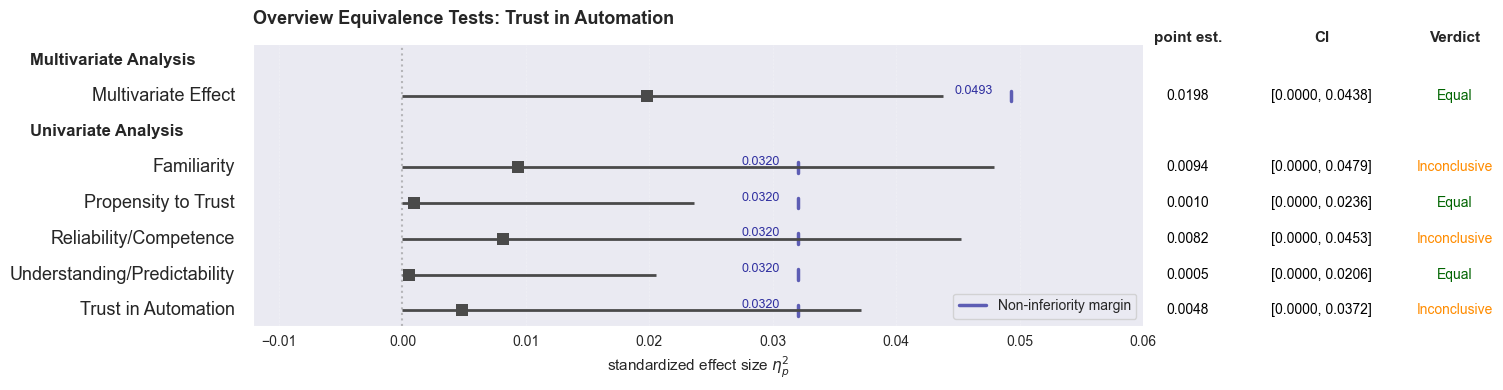

In [12]:
# load results from multivariate test
import json
with open(f'{output_path}multivariate_eq_test_res.json', 'r') as fp:
    multi_eq_test_res = json.load(fp)

# make combined plot
scales.scale_titles['multi'] = 'Multivariate Effect'

categories = {'Multivariate Analysis        ' : ['multi'],
              'Univariate Analysis        ' : tia_scales,
              }

fig, ax = plt.subplots(figsize=(15, 4))
plot_noninferiority_test(
    effect_size=[multi_eq_test_res['eta_sq_obs']] + coefs_eta,
    sesoi=[multi_eq_test_res['eq_margin']] + eq_margins,
    ci_lower_bounds=[multi_eq_test_res['ci_lower']] + cis_lower_eta,  # Pre-computed from F-distribution
    ci_upper_bounds=[multi_eq_test_res['ci_upper']] + cis_upper_eta,
    alpha=alpha,
    test_type='upper',
    mode = 'equivalence',
    variable_names=['multi'] + tia_scales,
    variable_labels=scales.scale_titles,
    categories=categories,
    title='Overview Equivalence Tests: Trust in Automation',
    xlabel='standardized effect size $\eta_{p}^{2}$',
    height_scale=0.6,
    column_title_pos_shift=0,
    estimate_name='point est.',
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}../combined_equivalence_test.png', dpi=150, transparent=True)
plt.show()

## Overview Table: All Regression Results

This table provides a comprehensive overview of all effects across the five Trust in Automation subscales:

- **Multivariate Effect (η²ₚ)**: Partial eta-squared from MANOVA showing the effect on the overall distribution across all 5 subscales
- **Individual Subscales (β)**: Standardized regression coefficients showing the directional effect on each subscale separately

All significance stars are based on Holm-adjusted p-values within effect families (group effect, main effects, interactions).

In [13]:
# Overview Table: Regression Coefficients for All TiA Subscales
from scripts.stats import format_effect_with_stars

# Create predictor label mapping
predictor_labels = {
    'group_effect': 'Group Effect (Uncertainty vs Control)',
    'age': 'Age',
    'gender': 'Gender',
    'education': 'Education',
    'ai_exp': 'AI Experience',
    'hcsds_c': 'Healthcare Trust - Competence',
    'hcsds_v': 'Healthcare Trust - Values',
    'ati': 'Affinity for Technology',
    'group_effect:age': 'Group x Age',
    'group_effect:gender': 'Group x Gender',
    'group_effect:education': 'Group x Education',
    'group_effect:ai_exp': 'Group x AI Experience',
    'group_effect:hcsds_c': 'Group x Healthcare Trust - Competence',
    'group_effect:hcsds_v': 'Group x Healthcare Trust - Values',
    'group_effect:ati': 'Group x Affinity for Technology'
}

# Load MANOVA results for multivariate effects
manova_df = pd.read_csv(f'{output_path}manova_results.csv', index_col=0)
# Exclude Intercept
manova_df = manova_df[manova_df.index != 'Intercept']

# Load all regression coefficient files
regression_data = {}
for subscale in tia_scales:
    df = pd.read_csv(f'{output_path}{subscale}_regression_coef.csv', index_col=0)
    # Exclude Intercept (no adjusted p-value)
    df = df[df.index != 'Intercept']
    regression_data[subscale] = df

# Build formatted table
results_table = pd.DataFrame(index=predictor_labels.keys())

# Add multivariate effect column (partial eta-squared with stars)
multivariate_values = []
for predictor in results_table.index:
    eta_sq = manova_df.loc[predictor, 'partial_eta_sq']
    p_adj = manova_df.loc[predictor, 'p_adj']
    multivariate_values.append(format_effect_with_stars(eta_sq, p_adj))

results_table['Multivariate Effect (eta_sq)'] = multivariate_values

# Add columns for each TiA subscale with (β) suffix
for subscale in tia_scales:
    df = regression_data[subscale]
    
    # Create formatted column with coefficient and stars
    formatted_values = []
    for predictor in results_table.index:
        coef = df.loc[predictor, 'coef']
        p_adj = df.loc[predictor, 'p_adj']
        formatted_values.append(format_effect_with_stars(coef, p_adj))

    
    # Use scale title as column name with (β) suffix
    col_name = scales.scale_titles[subscale] + ' (b)'
    results_table[col_name] = formatted_values

# Apply descriptive labels to row index
results_table.index = [predictor_labels[pred] for pred in results_table.index]

# Display table
print(results_table.to_string())

# Save to CSV
results_table.to_csv(f'{output_path}regression_coefficients_overview.csv')
print(f"\nTable saved to: {output_path}regression_coefficients_overview.csv")

                                      Multivariate Effect (eta_sq) Familiarity (b) Propensity to Trust (b) Reliability/Competence (b) Understanding/Predictability (b) Trust in Automation (b)
Group Effect (Uncertainty vs Control)                        0.020           0.175                  -0.040                     -0.096                           -0.034                  -0.101
Age                                                       0.186***          0.177*                0.192***                   0.202***                            0.063                0.317***
Gender                                                       0.014          -0.064                   0.072                      0.040                            0.152                   0.145
Education                                                   0.071*           0.067                  -0.045                      0.020                            0.060                   0.061
AI Experience                                